In [24]:
import os as os
import pandas as pd
import numpy as np
import sygma
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform, cdist
%matplotlib inline

#### WIP not for use in manuscript

In [2]:
TOP = os.getcwd().replace('notebooks', '')

In [3]:
raw_dat_dir = TOP + 'data/raw/'
processed_dat_dir = TOP + 'data/processed/'
interim_dat_dir = TOP + 'data/interim/'
figures_dir = TOP + 'reports/figures/'
external_dir = TOP + 'data/external/'

In [10]:
df = pd.read_excel(external_dir+'matches_expt_times_ivt_mx_040621.xlsx', sheet_name = 'insilico_expt_comparison')

In [11]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [17]:
df['Expt_Metab'] = df['Expt_Metab'].replace('ND', np.nan)

In [21]:
df.iloc[:,4:] = df.iloc[:,4:].fillna(0)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Source               140 non-null    object 
 1   DTXSID               140 non-null    object 
 2   Metabolite_INCHIKEY  140 non-null    object 
 3   Final_SMILES         140 non-null    object 
 4   Expt_Metab           140 non-null    float64
 5   Meteor               140 non-null    float64
 6   TIMES_InVivo         140 non-null    float64
 7   TIMES_InVitro        140 non-null    float64
dtypes: float64(4), object(4)
memory usage: 8.9+ KB


In [23]:
df.head()

,Source,DTXSID,Metabolite_INCHIKEY,Final_SMILES,Expt_Metab,Meteor,TIMES_InVivo,TIMES_InVitro
0,"2,4-TDA",DTXSID4020402,BATBGGSVKZESGJ-UHFFFAOYSA-N,CC(=O)Nc1cc(N)c(C)cc1O,1.0,1.0,1.0,0.0
1,"2,4-TDA",DTXSID4020402,CEKKEYTVRSICNQ-UHFFFAOYSA-N,Cc1cc(O)c(N)c(SCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC(...,0.0,0.0,0.0,1.0
2,"2,4-TDA",DTXSID4020402,DGBUOAIABOATGK-UHFFFAOYSA-N,CC(=O)Nc1cc(N)ccc1CO,0.0,1.0,0.0,0.0
3,"2,4-TDA",DTXSID4020402,DPKOCFTZJRJTQL-UHFFFAOYSA-N,Cc1cc(O)c(N)cc1N,1.0,1.0,1.0,1.0
4,"2,4-TDA",DTXSID4020402,DYLOOKKMCKMECT-UHFFFAOYSA-N,Cc1ccc(N=O)cc1N,0.0,0.0,0.0,1.0


In [67]:
df_times_iv = df[df['TIMES_InVivo']==1]

In [29]:
df.groupby(['Source', 'DTXSID'])[['Expt_Metab', 'Meteor', 'TIMES_InVivo', 'TIMES_InVitro']].sum()

,,Expt_Metab,Meteor,TIMES_InVivo,TIMES_InVitro
Source,DTXSID,,,,
"2,3-TDA",DTXSID4027494,0.0,14.0,8.0,19.0
"2,4-TDA",DTXSID4020402,9.0,19.0,5.0,15.0
"2,5-TDA",DTXSID6029123,1.0,18.0,2.0,15.0
"2,6-TDA",DTXSID4027319,4.0,8.0,4.0,11.0
"3,4-TDA",DTXSID9024930,0.0,15.0,8.0,18.0


In [45]:
df.DTXSID.unique()

array(['DTXSID4020402', 'DTXSID4027319', 'DTXSID4027494', 'DTXSID6029123',
       'DTXSID9024930'], dtype=object)

In [39]:
model_fingerprint_DF = df.loc[:,['Expt_Metab', 'Meteor', 'TIMES_InVivo', 'TIMES_InVitro']].transpose()
model_fingerprint_DF

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
Expt_Metab,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meteor,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
TIMES_InVivo,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
TIMES_InVitro,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


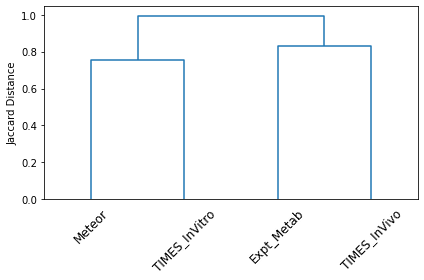

In [63]:
model_dist_vector = pdist(model_fingerprint_DF, 'jaccard')

cluster = hc.linkage(model_dist_vector, method = 'ward')
plot = hc.dendrogram(cluster, labels = ['Expt_Metab','Meteor', 'TIMES_InVivo', 'TIMES_InVitro'], leaf_rotation = 45)
plt.ylabel('Jaccard Distance')

plt.tight_layout()
plt.savefig(figures_dir+'Dendrogram_TDA_170821.png', bbox_inches='tight');

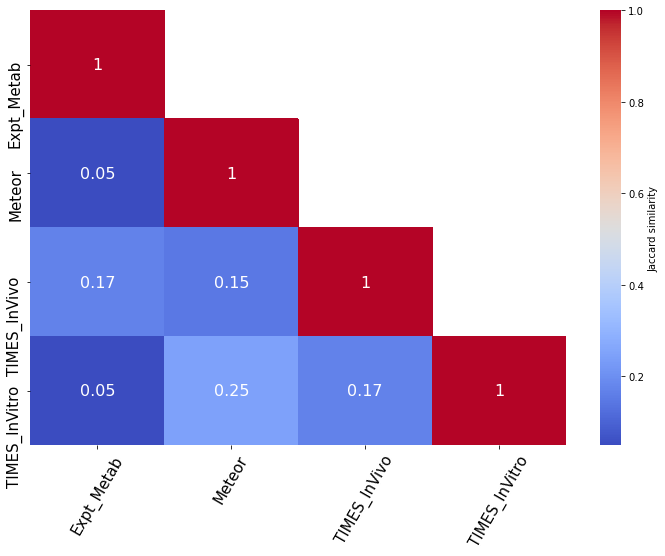

In [44]:
D_met = pd.DataFrame(squareform(model_dist_vector), columns = model_fingerprint_DF.index, index = model_fingerprint_DF.index)
S_met = 1-D_met.where(np.tril(np.ones(D_met.shape)).astype(np.bool))

plt.figure(figsize=(12, 8))
sns.heatmap(S_met.round(2), cmap = 'coolwarm',annot=True, cbar_kws={'label': 'Jaccard similarity'}, annot_kws={"size": 16})
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15, rotation = 60)
plt.savefig(figures_dir+'Similarity_TDA_170821.png', bbox_inches='tight');

In [60]:
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster


In [46]:
parents = pd.read_csv(external_dir+'TDAs.csv')

In [47]:
parents

,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,INCHIKEY,SMILES,QSAR_READY_SMILES
0,DTXSID4020402,DSSTox_Substance_Id,DTXSID4020402,"2,4-Diaminotoluene",VOZKAJLKRJDJLL-UHFFFAOYSA-N,CC1=C(N)C=C(N)C=C1,CC1=C(N)C=C(N)C=C1
1,DTXSID4027319,DSSTox_Substance_Id,DTXSID4027319,"2,6-Toluenediamine",RLYCRLGLCUXUPO-UHFFFAOYSA-N,CC1=C(N)C=CC=C1N,CC1=C(N)C=CC=C1N
2,DTXSID4027494,DSSTox_Substance_Id,DTXSID4027494,"2,3-Diaminotoluene",AXNUJYHFQHQZBE-UHFFFAOYSA-N,CC1=C(N)C(N)=CC=C1,CC1=C(N)C(N)=CC=C1
3,DTXSID6029123,DSSTox_Substance_Id,DTXSID6029123,"2-Methyl-1,4-benzenediamine",OBCSAIDCZQSFQH-UHFFFAOYSA-N,CC1=C(N)C=CC(N)=C1,CC1=C(N)C=CC(N)=C1
4,DTXSID9024930,DSSTox_Substance_Id,DTXSID9024930,"3,4-Diaminotoluene",DGRGLKZMKWPMOH-UHFFFAOYSA-N,CC1=CC=C(N)C(N)=C1,CC1=CC=C(N)C(N)=C1


In [48]:
parent_dict = {k:v for k,v in zip(parents['DTXSID'], parents['SMILES'])}

In [49]:
parent_smi_dict = {k:Chem.MolFromSmiles(v) for k,v in parent_dict.items()}

In [81]:
metab_dict = {}
for i,group in df.groupby('DTXSID'):
    key = [n for n in group['DTXSID'] if n !=' '][0]
    value = list(group['Final_SMILES'])
    metab_dict[key] = value

In [82]:
metab_smi_dict = {k:[Chem.MolFromSmiles(e) for e in v] for k,v in metab_dict.items()}

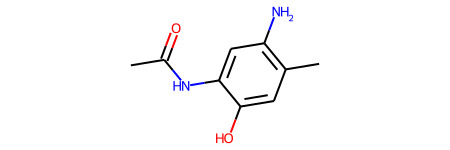

In [83]:
metab_smi_dict['DTXSID4020402'][0]

In [84]:
import sys

sys.path.append('/home/grace/Documents/python/read_across/src/models/')

import metabolism_sim as metab

In [85]:
mylst = []

for k in parent_dict.keys() & metab_dict.keys():
    a = parent_dict[k] 
    b = metab_dict[k]
    for n in range(0,len(b)):
        c = b[n]
        mylst.append([k,a,c])

In [86]:
len(mylst)

140

In [87]:
mylst2 = []

for k in parent_smi_dict.keys() & metab_smi_dict.keys():
    a = parent_smi_dict[k] 
    b = metab_smi_dict[k]
    b1 = metab_dict[k]
    a1 = parent_dict[k]
    for n in range(0,len(b)):
        c = b[n]
        d = b1[n]
        rxn = metab.genFragReaction(a, c)
        mylst2.append([k,rxn, a1, d])

In [88]:
reaction_DF = pd.DataFrame(mylst2, columns = ['Parent_DTXSID', 'Frag', 'Parent_smiles', 'Metabolite_smiles'])
reaction_DF.head()

,Parent_DTXSID,Frag,Parent_smiles,Metabolite_smiles
0,DTXSID4027494,[#7]-[#6].[#6](:[#6]:[#6]:[#6]):[#6]>>[#6](-[#...,CC1=C(N)C(N)=CC=C1,CC1=CC(=O)C=C(N)C1=O
1,DTXSID4027494,[#7]-[#6].[#6](:[#6]:[#6]:[#6]):[#6]>>[#7]=[#6...,CC1=C(N)C(N)=CC=C1,N=C1C(N)=CC(=O)C=C1CO
2,DTXSID4027494,[#7]>>[#6]-[#6](=[#8])-[#7],CC1=C(N)C(N)=CC=C1,CC(=O)Nc1c(C)cccc1N
3,DTXSID4027494,[#7]>>[#8](-[#16](=[#8])(=[#8])-[#8])-[#7],CC1=C(N)C(N)=CC=C1,Cc1cccc(N)c1NOS(=O)(=O)O
4,DTXSID4027494,[#7].[#6]>>[#6]-[#6](=[#8])-[#7].[#8]-[#6],CC1=C(N)C(N)=CC=C1,CC(=O)Nc1cccc(CO)c1N


In [89]:
frag_lst = list(set(reaction_DF['Frag'].tolist()))
print(len(frag_lst))

32


In [90]:
frag_dict = {}
for i,group in reaction_DF.groupby('Parent_DTXSID'):
    k = [n for n in group['Parent_DTXSID'] if n != ' '][0]
    v = list(set(group['Frag']))
    frag_dict[k] = v

In [91]:
metabFP_DF = pd.DataFrame()
for k,v in frag_dict.items():
    a = frag_dict[k]
    par_fp = [int(frag in a) for frag in frag_lst]
    metabFP_DF[k] = par_fp
metabFP_DF = metabFP_DF.transpose()
metabFP_DF.columns = ['metab_fp_%d'%i for i in metabFP_DF.columns]
metabFP_DF.head()


,metab_fp_0,metab_fp_1,metab_fp_2,metab_fp_3,metab_fp_4,metab_fp_5,metab_fp_6,metab_fp_7,metab_fp_8,metab_fp_9,...,metab_fp_22,metab_fp_23,metab_fp_24,metab_fp_25,metab_fp_26,metab_fp_27,metab_fp_28,metab_fp_29,metab_fp_30,metab_fp_31
DTXSID4020402,1,1,1,0,1,1,0,1,1,0,...,1,1,0,1,0,0,0,1,0,1
DTXSID4027319,1,1,1,0,1,1,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
DTXSID4027494,1,1,0,0,1,1,1,1,0,0,...,1,1,0,1,1,1,1,0,0,0
DTXSID6029123,1,1,0,1,1,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
DTXSID9024930,1,1,0,0,1,1,0,1,0,1,...,1,1,1,1,0,0,0,0,0,0


In [134]:
D_met = pd.DataFrame(squareform(pdist(metabFP_DF, 'jaccard')), columns = metabFP_DF.index, index = metabFP_DF.index)
S_met = 1-D_met
S_met.head()


,DTXSID4020402,DTXSID4027319,DTXSID4027494,DTXSID6029123,DTXSID9024930
DTXSID4020402,1.000000,0.636364,0.461538,0.565217,0.541667
DTXSID4027319,0.636364,1.000000,0.523810,0.666667,0.550000
DTXSID4027494,0.461538,0.523810,1.000000,0.454545,0.571429
DTXSID6029123,0.565217,0.666667,0.454545,1.000000,0.550000
DTXSID9024930,0.541667,0.550000,0.571429,0.550000,1.000000


In [96]:
def mk_fp(df):
    MOLS = dict(zip(df['DTXSID'], df['SMILES']))
    MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
    MOLS = {i:j for i,j in MOLS.items() if j}
    FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
    FP0.index=MOLS.keys()
    FP0.columns = ['mrgn_%d'%i for i in FP0.columns]
    return FP0

In [99]:
mgrn_parents = mk_fp(parents)

In [100]:
D_txps = pd.DataFrame(squareform(pdist(mgrn_parents, 'jaccard')), columns = mgrn_parents.index, index = mgrn_parents.index)
S_txps = 1-D_txps

In [101]:
S_txps

,DTXSID4020402,DTXSID4027319,DTXSID4027494,DTXSID6029123,DTXSID9024930
DTXSID4020402,1.000000,0.266667,0.312500,0.448276,0.322581
DTXSID4027319,0.266667,1.000000,0.407407,0.266667,0.275862
DTXSID4027494,0.312500,0.407407,1.000000,0.312500,0.281250
DTXSID6029123,0.448276,0.266667,0.312500,1.000000,0.413793
DTXSID9024930,0.322581,0.275862,0.281250,0.413793,1.000000


In [104]:
name_dict = {'DTXSID4020402': '2,4-TDA', 'DTXSID9024930': '3,4-TDA', 'DTXSID3025881':'DTXSID3025881', 'DTXSID4027319':'2,6-TDA',
       'DTXSID4027494': '2,3-TDA', 'DTXSID6029123': '2,5-TDA'}

In [109]:
S_txps.index = S_txps.index.map(name_dict)

In [112]:
S_txps.columns = S_txps.columns.map(name_dict)

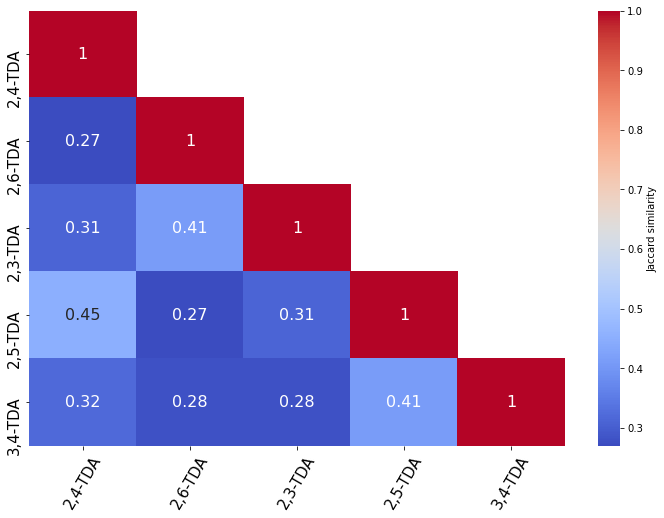

In [114]:

S_mgrn = S_txps.where(np.tril(np.ones(S_txps.shape)).astype(np.bool))

plt.figure(figsize=(12, 8))
sns.heatmap(S_mgrn.round(2), cmap = 'coolwarm',annot=True, cbar_kws={'label': 'Jaccard similarity'}, annot_kws={"size": 16})
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15, rotation = 60)
plt.savefig(figures_dir+'Similarity_parent_TDAs.png', bbox_inches='tight');

In [136]:
S_met.index = S_met.index.map(name_dict)
S_met.columns = S_met.columns.map(name_dict)

In [137]:
S_met.head()

,"2,4-TDA","2,6-TDA","2,3-TDA","2,5-TDA","3,4-TDA"
"2,4-TDA",1.000000,0.636364,0.461538,0.565217,0.541667
"2,6-TDA",0.636364,1.000000,0.523810,0.666667,0.550000
"2,3-TDA",0.461538,0.523810,1.000000,0.454545,0.571429
"2,5-TDA",0.565217,0.666667,0.454545,1.000000,0.550000
"3,4-TDA",0.541667,0.550000,0.571429,0.550000,1.000000


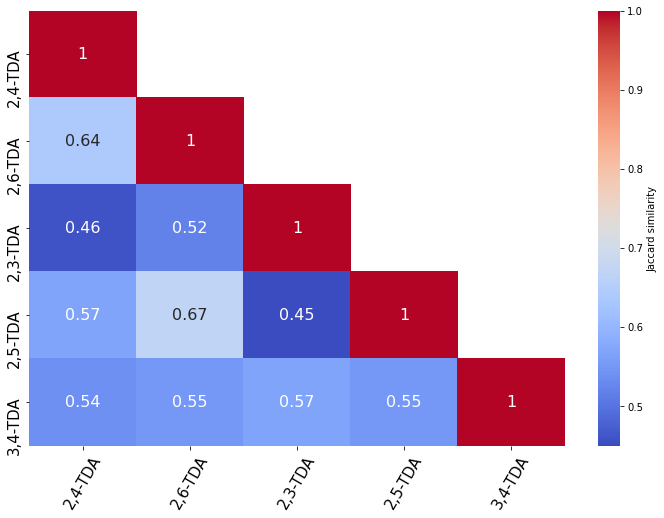

In [117]:
S_met = S_met.where(np.tril(np.ones(S_met.shape)).astype(np.bool))

plt.figure(figsize=(12, 8))
sns.heatmap(S_met.round(2), cmap = 'coolwarm',annot=True, cbar_kws={'label': 'Jaccard similarity'}, annot_kws={"size": 16})
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15, rotation = 60)
plt.savefig(figures_dir+'Similarity_metabFP_TDAs.png', bbox_inches='tight');

In [139]:
long_form_txps = S_txps.unstack()
long_form_txps.index.rename(['DTXSID_x', 'DTXSID_y'], inplace = True)
long_form_txps = long_form_txps.to_frame('Jaccard_chem').reset_index()
long_form_met = S_met.unstack()
long_form_met.index.rename(['DTXSID_x', 'DTXSID_y'], inplace = True)
long_form_met = long_form_met.to_frame('Jaccard_met').reset_index()
long_form_met.head()
long_met_chem = pd.merge(long_form_met, long_form_txps, on = ['DTXSID_x','DTXSID_y'], how = 'inner')
long_met_chem.head()

,DTXSID_x,DTXSID_y,Jaccard_met,Jaccard_chem
0,"2,4-TDA","2,4-TDA",1.000000,1.000000
1,"2,4-TDA","2,6-TDA",0.636364,0.266667
2,"2,4-TDA","2,3-TDA",0.461538,0.312500
3,"2,4-TDA","2,5-TDA",0.565217,0.448276
4,"2,4-TDA","3,4-TDA",0.541667,0.322581


Text(0, 0.5, 'Metabolic_similarity')

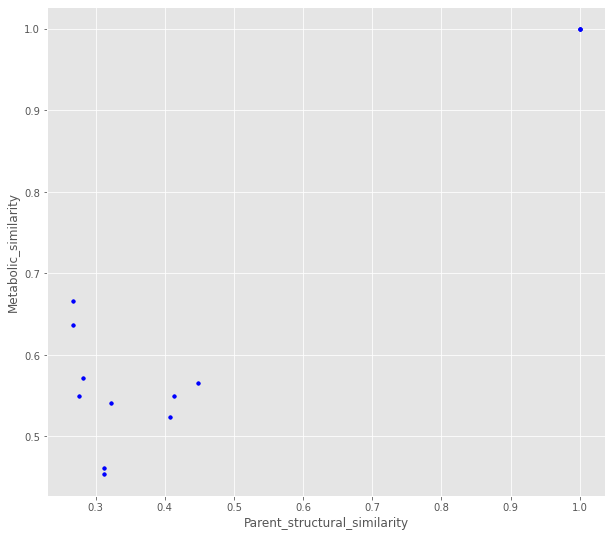

In [142]:
plt.style.use('ggplot')
plt.figure(figsize = (10,9))
plt.plot(long_met_chem['Jaccard_chem'], long_met_chem['Jaccard_met'], marker = '.', linestyle = 'none', color = 'b')
plt.xlabel('Parent_structural_similarity')
plt.ylabel('Metabolic_similarity')

In [143]:
nt2 = long_met_chem[long_met_chem['DTXSID_x'] =='3,4-TDA'].sort_values(by = ['Jaccard_chem', 'Jaccard_met'], ascending = [False, False]).head(10)
nt2 

,DTXSID_x,DTXSID_y,Jaccard_met,Jaccard_chem
24,"3,4-TDA","3,4-TDA",1.000000,1.000000
23,"3,4-TDA","2,5-TDA",0.550000,0.413793
20,"3,4-TDA","2,4-TDA",0.541667,0.322581
22,"3,4-TDA","2,3-TDA",0.571429,0.281250
21,"3,4-TDA","2,6-TDA",0.550000,0.275862
